# Dirichlet Process Mixture Model

This notebook implements a simple non-parametric Bayesian model called a 
[Dirichlet Process Mixture Model](https://en.wikipedia.org/wiki/Dirichlet_process)
using a stick-breaking formulation.


In [1]:
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt

from flippy import flip, condition, mem, infer, keep_deterministic
from flippy.distributions import Beta, Normal, Gamma

In [2]:
@mem
def break_stick(c, concentration=1.0):
    prob = Beta(1, concentration).sample()
    return prob

@mem
def category_params(c):
    return Normal(0, 5).sample(), (1/Gamma(1, 1).sample())**.5

def sample_category(c=None):
    c = c or 0
    if flip(break_stick(c)):
        return c, category_params(c)
    return sample_category(c + 1)

def category_dist(cs):
    max_c = max(cs)
    cdist = {c: (break_stick(c), category_params(c)) for c in range(max_c + 1)}
    return cdist

@infer(method="MetropolisHastings", samples=500, burn_in=1000, thinning=10, seed=52512)
def model(data):
    cs = ()
    for x in data:
        c, (mu, sd) = sample_category()
        Normal(mu, sd).observe(x)
        cs += (c,)
    return category_dist(cs)


In [3]:
dataset1 = (2.77, 2.85, 1.98, 1.67, 1.04, -0.4, -0.1, 6.8, 8.7, 6.0, 8.4, 6.0, 7.8, 7.3, 6.8, 6.5, 6.8)
dist = model(dataset1)

Text(0.5, 1.0, 'Cluster Count Distribution')

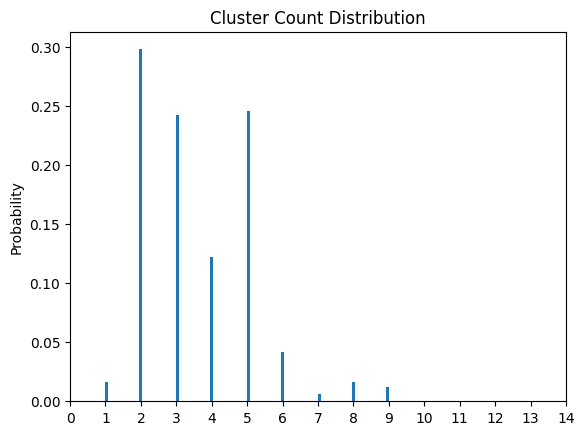

In [4]:
# cluster count distribution
ax = dist.marginalize(lambda cdist: len(cdist)).plot()
ax.set_xticks(np.arange(0, 15, 1))
ax.set_title("Cluster Count Distribution")

(-0.01, 0.3)

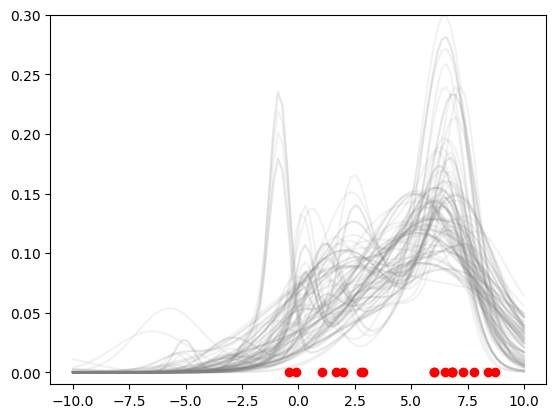

In [5]:
def plot_dp_mixture_sample(cdist, ax, **kws):
    cat_dist = {c: prob for c, (prob, _) in cdist.items()}
    for c, (prob, _) in cdist.items():
        for c_ in range(c + 1, max(cdist) + 1):
            cat_dist[c_] *= 1 - prob

    prob = np.zeros(100)
    for c, (_, (mu, sd)) in cdist.items():
        prob += stats.norm(mu, sd).pdf(np.linspace(-10, 10, 100)) * cat_dist[c]

    ax.plot(np.linspace(-10, 10, 100), prob, **kws)

fig, ax = plt.subplots()
ax.plot(dataset1, [0] * len(dataset1), "o", color="red")
for _ in range(100):
    cdist = dist.sample()
    plot_dp_mixture_sample(cdist, ax, alpha=.1, color="grey")
ax.set_ylim(-0.01, 0.3)

In [6]:
dataset2 = (2.0, 2.15, 1.98, 1.67, 1.54, -2.4, -2.1, 5.5, 6.8, 8.7, 6.0, 8.4, 9.1, 7.8, 7.3, 6.8, 6.5, 6.8)
dist = model(dataset2)

Text(0.5, 1.0, 'Cluster Count Distribution')

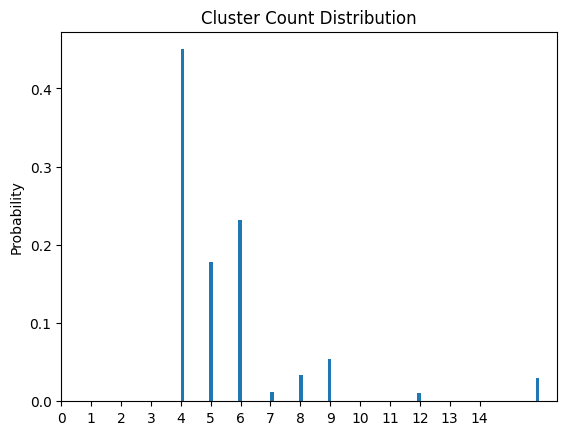

In [7]:
ax = dist.marginalize(lambda cdist: len(cdist)).plot()
ax.set_xticks(np.arange(0, 15, 1))
ax.set_title("Cluster Count Distribution")

(-0.01, 0.5)

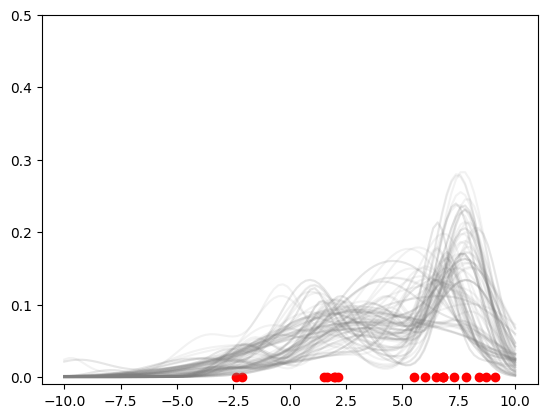

In [8]:
fig, ax = plt.subplots()
ax.plot(dataset2, [0] * len(dataset2), "o", color="red")
for _ in range(100):
    cdist = dist.sample()
    plot_dp_mixture_sample(cdist, ax, alpha=.1, color="grey")
ax.set_ylim(-0.01, 0.5)